## 환경 설정

In [ ]:
import torch
from torchvision import transforms
import torchvision
import PIL
import matplotlib.pyplot as plt
import pathlib
import os
import pickle
import warnings
import copy
import numpy as np
import math
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify

/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify


In [ ]:
!pip install ninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 11.2 MB/s eta 0:00:00


In [ ]:
import ninja

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda


## Model load

In [ ]:
model_list=list(pathlib.Path('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/pretrained').glob('*.pkl'))
model_list

[PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/pretrained/ffhq.pkl'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/pretrained/metfaces.pkl')]

In [ ]:
with open(model_list[0], 'rb') as f:
    G = pickle.load(f)['G_ema'].requires_grad_(False).to(device)#.cuda()  # torch.nn.Module
    
G=G.eval()

## Random Test

In [ ]:
z_1 = torch.randn([1, G.z_dim],device=device)#.to(device)#.cuda()    # latent codes
z_2 = torch.randn([1, G.z_dim],device=device)
c = None                 # class labels (not used in this example)
#img = G(z, c)

In [ ]:
w_1 = G.mapping(z_1,c,truncation_psi=0.5, truncation_cutoff=8)
w_2 = G.mapping(z_2,c,truncation_psi=0.5, truncation_cutoff=8)
img_1 = G.synthesis(w_1, noise_mode='const', force_fp32=True)
img_2 = G.synthesis(w_2, noise_mode='const', force_fp32=True)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


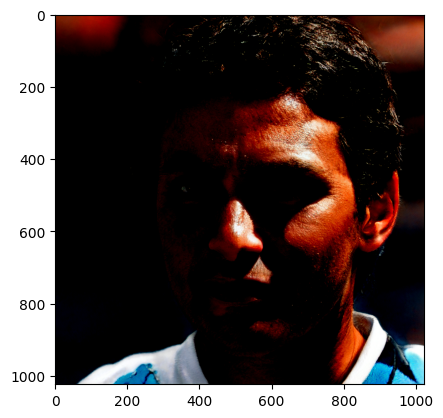

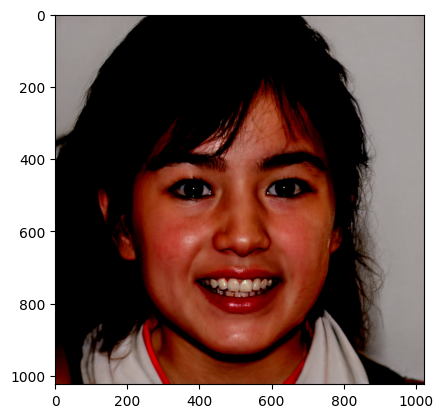

In [ ]:
img_1=img_1.to('cpu')
plt.imshow(img_1[0].permute(1,2,0))
plt.show()
img_2=img_2.to('cpu')
plt.imshow(img_2[0].permute(1,2,0))
plt.show()

In [ ]:
##벡터 2개씩 바꾸기
fig,axes=plt.subplots(6,3,figsize=(15,30))
for i,ax in zip(range(18),axes.ravel()):
  w_blend=w_1.clone()
  w_blend[0][i]=w_2[0][i]
  img_blend = G.synthesis(w_blend, noise_mode='const', force_fp32=True)
  img_blend=img_blend.to('cpu')
  ax.imshow(img_blend[0].permute(1,2,0))
  ax.set_title('{} vector replaced'.format(i))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
## 0부터 2개씩 누적 변경
fig,axes=plt.subplots(6,3,figsize=(15,30))
for i,ax in zip(range(18),axes.ravel()):
  w_blend=w_1.clone()
  w_blend[0][0:i]=w_2[0][0:i]
  img_blend = G.synthesis(w_blend, noise_mode='const', force_fp32=True)
  img_blend=img_blend.to('cpu')
  ax.imshow(img_blend[0].permute(1,2,0))
  ax.set_title('0~{} vector replaced'.format(i))

Output hidden; open in https://colab.research.google.com to view.

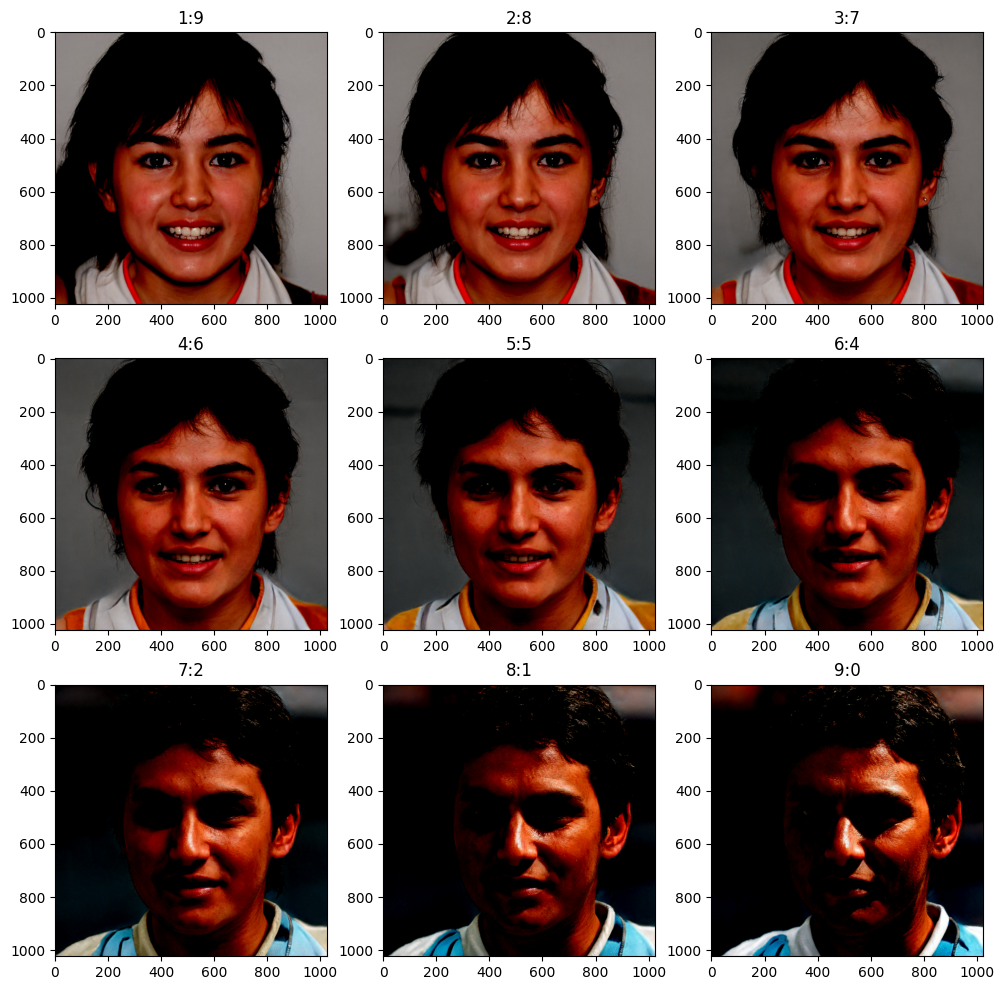

In [ ]:
##선형보간
fig,axes=plt.subplots(3,3,figsize=(12,12))
for rate,ax in zip(np.arange(0.1,1,0.1),axes.ravel()):
  w_blend=rate*w_1+(1-rate)*w_2
  img_blend = G.synthesis(w_blend, noise_mode='const', force_fp32=True)
  img_blend=img_blend.to('cpu')
  ax.imshow(img_blend[0].permute(1,2,0))
  ax.set_title('{}:{}'.format(int(rate*10),int((1-rate)*10)))

## Specified Image Blend

In [ ]:
w_2=torch.Tensor(np.load('/content/drive/MyDrive/StyleGAN/out/Venus/projected_w.npz')['w'])
w_1=torch.Tensor(np.load('/content/drive/MyDrive/StyleGAN/out/rose2/projected_w.npz')['w'])

In [ ]:
##벡터 1개씩 바꾸기
fig,axes=plt.subplots(6,3,figsize=(15,30))
for i,ax in zip(range(18),axes.ravel()):
  w_blend=w_2.clone()
  w_blend[0][i]=w_1[0][i]
  w_blend=w_blend.to(device)
  img_blend = G.synthesis(w_blend, noise_mode='const')
  img_blend = (img_blend.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img_blend=img_blend.to('cpu')
  ax.imshow(img_blend[0])
  ax.set_title('{}th vector replaced'.format(i))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
## 0부터 1개씩 누적 변경
fig,axes=plt.subplots(6,3,figsize=(15,30))
for i,ax in zip(range(18),axes.ravel()):
  w_blend=w_2.clone()
  w_blend[0][0:i]=w_1[0][0:i]
  w_blend=w_blend.to(device)
  img_blend = G.synthesis(w_blend, noise_mode='const')
  img_blend = (img_blend.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img_blend=img_blend.to('cpu')
  ax.imshow(img_blend[0])
  ax.set_title('{}~{} vector replaced'.format(0,i))

Output hidden; open in https://colab.research.google.com to view.

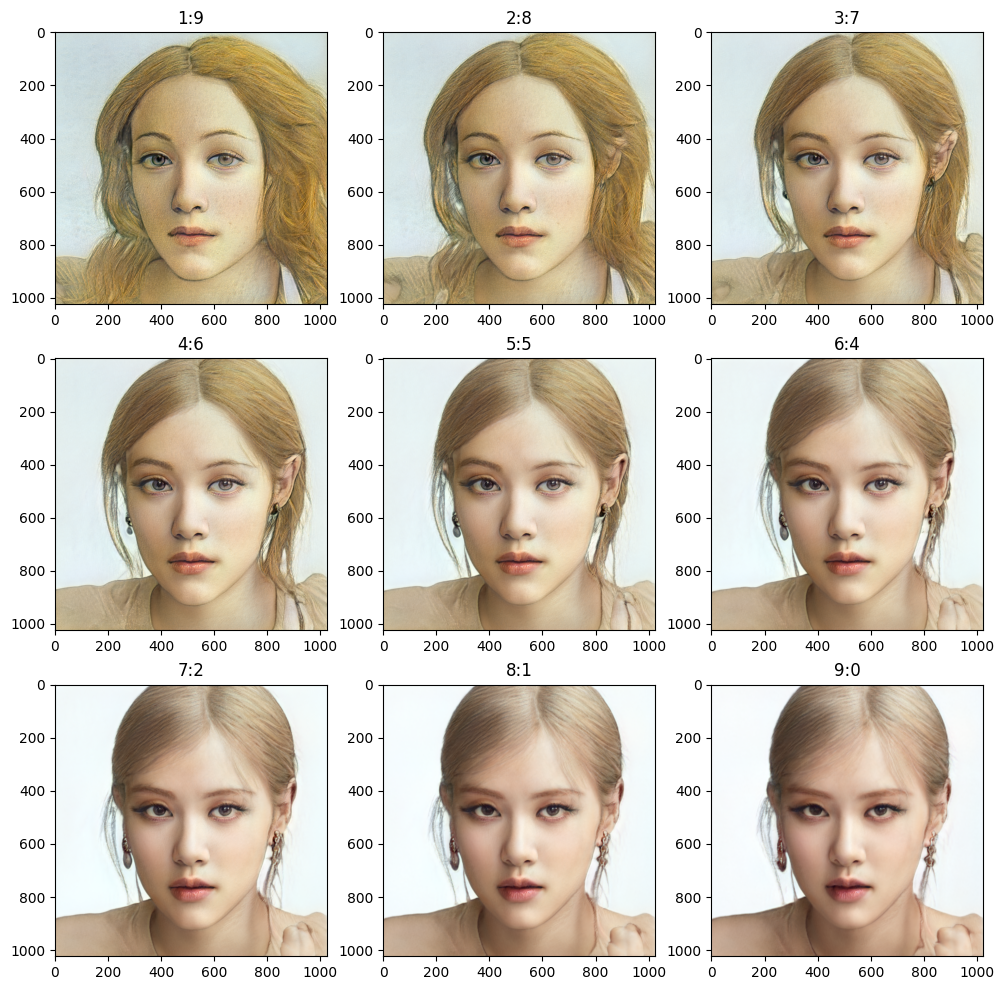

In [ ]:
##선형보간
fig,axes=plt.subplots(3,3,figsize=(12,12))
for rate,ax in zip(np.arange(0.1,1,0.1),axes.ravel()):
  w_blend=rate*w_1+(1-rate)*w_2
  w_blend=w_blend.to(device)
  img_blend = G.synthesis(w_blend, noise_mode='const')
  img_blend = (img_blend.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img_blend=img_blend.to('cpu')
  ax.imshow(img_blend[0])
  ax.set_title('{}:{}'.format(int(rate*10),int((1-rate)*10)))

Text(0.5, 1.0, '0~7 vector replaced')

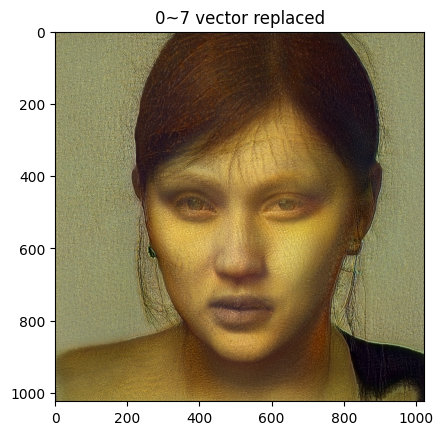

In [ ]:
w_blend=w_2.clone()
w_blend[0][0:7]=w_1[0][0:7]
w_blend=w_blend.to(device)
img_blend = G.synthesis(w_blend, noise_mode='const')
img_blend = (img_blend.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
img_blend=img_blend.to('cpu')
plt.imshow(img_blend[0])
plt.title('{}~{} vector replaced'.format(0,7))

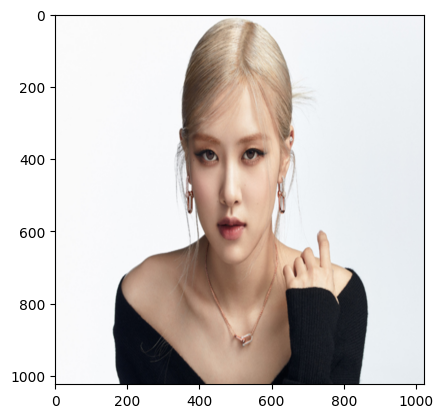

In [ ]:
test=PIL.Image.open('./images/normal_face/rose2.jpeg')
transform=transforms.Compose([transforms.Resize([1024,1024]),transforms.ToTensor()])
test=transform(test)
plt.imshow(test.permute(1,2,0))

In [ ]:
torchvision.utils.save_image(test,'/content/drive/MyDrive/StyleGAN/images/resized_tensor/rose2.png')

## FFHQ Dataset preprocessing

In [ ]:
face_file_path='./images/normal_face/myungsoo.jpeg'

- landmark detection

In [ ]:
from PIL import Image 
from IPython.display import display

def display_image_from_file(image_name):
  # Reference: https://stackoverflow.com/a/50723518
  
  image_content = Image.open(image_name)
  display(image_content)

  return

def display_image_from_array(array):
  # Reference: https://gist.github.com/kylemcdonald/2f1b9a255993bf9b2629

  image_content = Image.fromarray(array)
  display(image_content) 

  return    
     

In [ ]:
import sys
import os
import dlib
import glob

In [ ]:
def detect_face_landmarks(face_file_path=None,
                          predictor_path=None,
                          img=None):
  # References:
  # -   http://dlib.net/face_landmark_detection.py.html
  # -   http://dlib.net/face_alignment.py.html

  if predictor_path is None:
    predictor_path = './shape_predictor_68_face_landmarks.dat'

  # Load all the models we need: a detector to find the faces, a shape predictor
  # to find face landmarks so we can precisely localize the face
  detector = dlib.get_frontal_face_detector()
  shape_predictor = dlib.shape_predictor(predictor_path)

  if img is None:
    # Load the image using Dlib
    print("Processing file: {}".format(face_file_path))
    img = dlib.load_rgb_image(face_file_path)

  shapes = list()

  # Ask the detector to find the bounding boxes of each face. The 1 in the
  # second argument indicates that we should upsample the image 1 time. This
  # will make everything bigger and allow us to detect more faces.
  dets = detector(img, 1)
    
  num_faces = len(dets)
  print("Number of faces detected: {}".format(num_faces))

  # Find the face landmarks we need to do the alignment.
  faces = dlib.full_object_detections()
  for d in dets:
      print("Left: {} Top: {} Right: {} Bottom: {}".format(
          d.left(), d.top(), d.right(), d.bottom()
      ))

      shape = shape_predictor(img, d)
      faces.append(shape)

  return faces

In [ ]:
faces = detect_face_landmarks(face_file_path=face_file_path)

Processing file: ./images/normal_face/myungsoo.jpeg
Number of faces detected: 1
Left: 253 Top: 110 Right: 382 Bottom: 239


In [ ]:
import collections

plot_style = dict(marker='o',
                  markersize=4,
                  linestyle='-',
                  lw=2)

pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
pred_types = {'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
              'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
              'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
              'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
              'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
              'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
              'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
              'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
              'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
              }

In [ ]:
import matplotlib.pyplot as plt

def display_landmarks_raw(input_img, preds=None, fig_size=None):
  # This is a raw copy from:
  # https://github.com/1adrianb/face-alignment/blob/master/examples/detect_landmarks_in_image.py

  if fig_size is None:
    fig_size = plt.figaspect(.5)

  fig = plt.figure(figsize=fig_size)
  ax = fig.add_subplot(1, 1, 1) # only display one image
  ax.imshow(input_img)

  if preds is not None:
    for pred_type in pred_types.values():
        ax.plot(preds[pred_type.slice, 0],
                preds[pred_type.slice, 1],
                color=pred_type.color, **plot_style)

  ax.axis('off')

  return

In [ ]:
from skimage import io

def display_landmarks(image_name, 
                      dlib_output_faces=None, 
                      face_no=0,
                      fig_size=None):
  
  if fig_size is None:
    fig_size = [15, 15]

  input_img = io.imread(image_name)

  if dlib_output_faces is None:
    dlib_output_faces = detect_face_landmarks(face_file_path=image_name,
                                              img=input_img)

  try:
    current_face = dlib_output_faces[face_no]

  except IndexError:
    current_face = None

    print('No face found for index n°{} (max={}).'.format(
        face_no, 
        len(dlib_output_faces)-1,
        ))

  if current_face is None:
    preds = None
  else:
    face_parts = current_face.parts()
    
    preds = np.array([
                      [v.x, v.y] 
                      for v in face_parts
                      ])    
    
  display_landmarks_raw(input_img=input_img, 
                        preds=preds,
                        fig_size=fig_size)  

  return

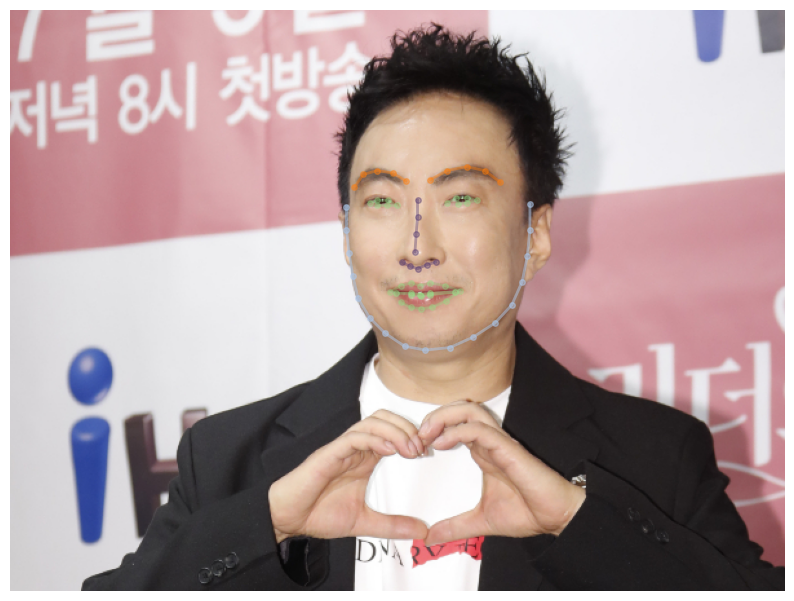

In [ ]:
face_no=0
fig_size=[10,10]

display_landmarks(image_name=face_file_path,
                  dlib_output_faces=faces,
                  face_no=face_no,
                  fig_size=fig_size)

- align no.1

In [ ]:
img = dlib.load_rgb_image(face_file_path)

thumbnail_size = 512
thumbnails = dlib.get_face_chips(img, faces, size=thumbnail_size)

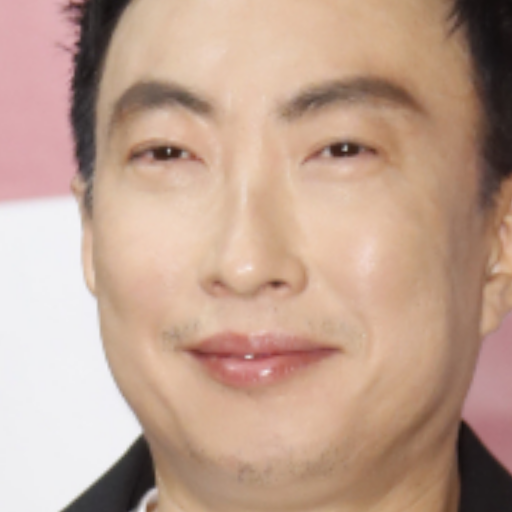

In [ ]:
display_image_from_array(thumbnails[0])

- align no.2

In [ ]:
import sys
import requests
import html
import hashlib
import PIL.ImageFile
import scipy.ndimage
import threading
import queue
import time
import json
import uuid
import argparse
import itertools
import shutil
from collections import OrderedDict, defaultdict

# Reference: https://github.com/NVlabs/ffhq-dataset/blob/master/download_ffhq.py

def recreate_aligned_images(json_data, 
                            dst_dir='realign1024x1024',
                            output_size=1024, 
                            transform_size=4096, 
                            enable_padding=True):
    print('Recreating aligned images...')
    if dst_dir:
        os.makedirs(dst_dir, exist_ok=True)

    for item_idx, item in enumerate(json_data.values()):
        print('\r%d / %d ... ' % (item_idx, len(json_data)), end='', flush=True)

        # Parse landmarks.
        # pylint: disable=unused-variable
        lm = np.array(item['in_the_wild']['face_landmarks'])
        lm_chin          = lm[0  : 17]  # left-right
        lm_eyebrow_left  = lm[17 : 22]  # left-right
        lm_eyebrow_right = lm[22 : 27]  # left-right
        lm_nose          = lm[27 : 31]  # top-down
        lm_nostrils      = lm[31 : 36]  # top-down
        lm_eye_left      = lm[36 : 42]  # left-clockwise
        lm_eye_right     = lm[42 : 48]  # left-clockwise
        lm_mouth_outer   = lm[48 : 60]  # left-clockwise
        lm_mouth_inner   = lm[60 : 68]  # left-clockwise

        # Calculate auxiliary vectors.
        eye_left     = np.mean(lm_eye_left, axis=0)
        eye_right    = np.mean(lm_eye_right, axis=0)
        eye_avg      = (eye_left + eye_right) * 0.5
        eye_to_eye   = eye_right - eye_left
        mouth_left   = lm_mouth_outer[0]
        mouth_right  = lm_mouth_outer[6]
        mouth_avg    = (mouth_left + mouth_right) * 0.5
        eye_to_mouth = mouth_avg - eye_avg

        # Choose oriented crop rectangle.
        print(eye_to_mouth.shape)
        x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
        x /= np.hypot(*x)
        x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
        y = np.flipud(x) * [-1, 1]
        c = eye_avg + eye_to_mouth * 0.1
        quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
        qsize = np.hypot(*x) * 2

        # Load in-the-wild image.
        src_file = item['in_the_wild']['file_path']
        img = PIL.Image.open(src_file)

        # Shrink.
        shrink = int(np.floor(qsize / output_size * 0.5))
        if shrink > 1:
            rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
            img = img.resize(rsize, PIL.Image.ANTIALIAS)
            quad /= shrink
            qsize /= shrink

        # Crop.
        border = max(int(np.rint(qsize * 0.1)), 3)
        crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
        crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
        if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
            img = img.crop(crop)
            quad -= crop[0:2]

        # Pad.
        pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
        pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
        if enable_padding and max(pad) > border - 4:
            pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
            img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
            h, w, _ = img.shape
            y, x, _ = np.ogrid[:h, :w, :1]
            mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
            blur = qsize * 0.02
            img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
            img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
            img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
            quad += pad[:2]

        # Transform.
        img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
        if output_size < transform_size:
            img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

        # Save aligned image.
        dst_subdir = os.path.join(dst_dir, '%05d' % (item_idx - item_idx % 1000))
        os.makedirs(dst_subdir, exist_ok=True)
        img.save(os.path.join(dst_subdir, '%05d.png' % item_idx))

    # All done.
    print('\r%d / %d ... done' % (len(json_data), len(json_data)))

    return

In [ ]:

# The first face which is detected:
# NB: we assume that there is exactly one face per picture!
f = faces[0]

parts = f.parts()

num_face_landmarks=68

v = np.zeros(shape=(num_face_landmarks, 2))
for k, e in enumerate(parts):
  v[k, :] = [e.x, e.y]

In [ ]:
json_data = dict()

item_idx = 0

json_data[item_idx] = dict()
json_data[item_idx]['in_the_wild'] = dict()
json_data[item_idx]['in_the_wild']['file_path'] = face_file_path
json_data[item_idx]['in_the_wild']['face_landmarks'] = v

In [ ]:
recreate_aligned_images(json_data)

Recreating aligned images...
0 / 1 ... (2,)
1 / 1 ... done


In [ ]:
face_file_path

'./images/normal_face/myungsoo.jpeg'

In [ ]:
ffhq_aligned_image_name=face_file_path.split('/')[-1].split('.')[0]+'.jpg'
!cp './realign1024x1024/00000/00000.png' $ffhq_aligned_image_name

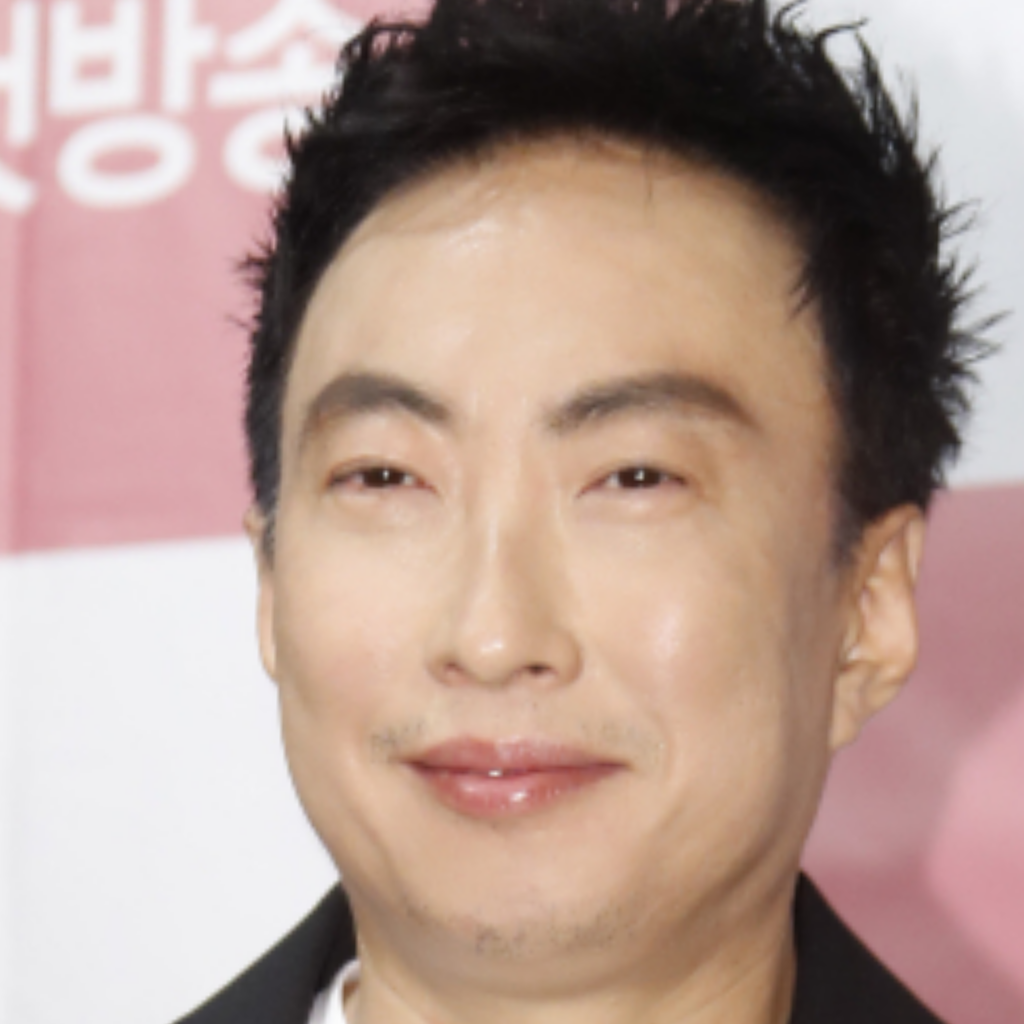

In [ ]:
display_image_from_file(ffhq_aligned_image_name)

## project image to laten vector

In [ ]:
#click option
#('--network', 'network_pkl', help='Network pickle filename', required=True)
#('--target', 'target_fname', help='Target image file to project to', required=True, metavar='FILE')
#('--num-steps',              help='Number of optimization steps', type=int, default=1000, show_default=True)
#('--seed',                   help='Random seed', type=int, default=303, show_default=True)
#('--save-video',             help='Save an mp4 video of optimization progress', type=bool, default=True, show_default=True)
#('--outdir',                 help='Where to save the output images', required=True, metavar='DIR')
#('--verbose',                help='verbose', type=bool, default=True)
#('--extend',                help='Want to project with extended w(18vectors)', type=bool, default=False))

In [ ]:
!python projector_custom.py --outdir=./out/myungsoo --target=./realign1024x1024/00000/myungsoo.png --network=./pretrained/ffhq.pkl --save-video=False --verbose=True --extend=True --num-steps=5000

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
step    2/5000: dist 0.78 loss 27640.76
step    3/5000: dist 0.90 loss 27544.90
step    4/5000: dist 0.79 loss 27353.39
step    5/5000: dist 0.83 loss 27069.78
step    6/5000: dist 0.78 loss 26698.24
step    7/5000: dist 0.81 loss 26243.79
step    8/5000: dist 0.73 loss 25711.82
step    9/5000: dist 0.84 loss 25109.11
step   10/5000: dist 0.76 loss 24442.59
step   11/5000: dist 0.80 loss 23719.23
step   12/5000: dist 0.88 loss 22944.30
step   13/5000: dist 0.85 loss 22122.67
step   14/5000: dist 0.82 loss 21259.74
step   15/5000: dist 0.88 loss 20361.19
step   16/5000: dist 0.84 loss 19432.90
step   17/5000: dist 0.76 loss 18481.10
step   18/5000: dist 0.80 loss 17512.12
step   19/5000: dist 1.01 loss 16531.76
step   20/5000: dist 0.83 loss 15544.97
step   21/5000: dist 0.75 loss 14557.57
step   22/5000: dist 0.91 loss 13574.09
step   23/5000: dist 0.86 loss 12598.02
step   24/5000: dist 0.89 loss 11634.40
step   25/5000: dist 0.90 loss 10689.49
step

In [ ]:
!python projector_custom.py --outdir=./out/macron --target=./realign1024x1024/00000/macron.png --network=./pretrained/ffhq.pkl --save-video=False --verbose=True --extend=True --num-steps=5000

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
step    2/5000: dist 0.88 loss 27640.86
step    3/5000: dist 0.94 loss 27544.94
step    4/5000: dist 0.87 loss 27353.47
step    5/5000: dist 0.85 loss 27069.80
step    6/5000: dist 0.83 loss 26698.29
step    7/5000: dist 0.93 loss 26243.91
step    8/5000: dist 0.81 loss 25711.89
step    9/5000: dist 0.87 loss 25109.13
step   10/5000: dist 0.84 loss 24442.67
step   11/5000: dist 0.78 loss 23719.21
step   12/5000: dist 0.88 loss 22944.30
step   13/5000: dist 0.90 loss 22122.72
step   14/5000: dist 0.78 loss 21259.71
step   15/5000: dist 0.93 loss 20361.24
step   16/5000: dist 0.90 loss 19432.96
step   17/5000: dist 0.77 loss 18481.11
step   18/5000: dist 0.83 loss 17512.14
step   19/5000: dist 0.99 loss 16531.74
step   20/5000: dist 0.84 loss 15544.99
step   21/5000: dist 0.82 loss 14557.63
step   22/5000: dist 0.87 loss 13574.06
step   23/5000: dist 0.89 loss 12598.06
step   24/5000: dist 0.88 loss 11634.39
step   25/5000: dist 0.88 loss 10689.47
step

## G net with image mapped into latent vector

In [ ]:
with open(model_list[0], 'rb') as f:
    G = pickle.load(f)['G_ema'].requires_grad_(False).to(device)#.cuda()  # torch.nn.Module
    
G=G.eval()

(1, 18, 512)


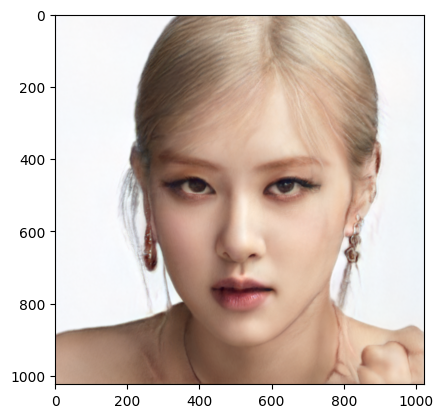

In [ ]:
projected_w='/content/drive/MyDrive/StyleGAN/out/rose2/projected_w18_5000.npz'

ws = np.load(projected_w)['w']
print(ws.shape)
ws = torch.tensor(ws, device=device) # pylint: disable=not-callable
assert ws.shape[1:] == (G.num_ws, G.w_dim)
for idx, w in enumerate(ws):
    img = G.synthesis(w.unsqueeze(0), noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8) #G로 생성하면 정규화돼서 나옴
    img=img.to('cpu')
    plt.imshow(img[0])

(1, 18, 512)


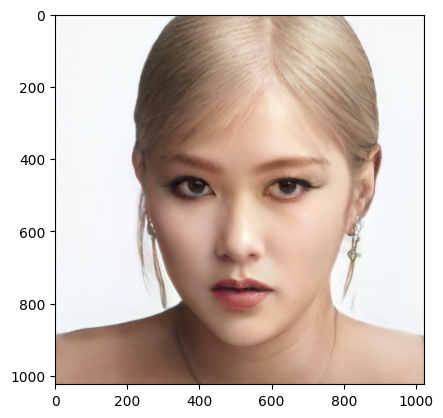

In [ ]:
projected_w='/content/drive/MyDrive/StyleGAN/out/rose2/projected_w1.npz'

ws = np.load(projected_w)['w']
print(ws.shape)
ws = torch.tensor(ws, device=device) # pylint: disable=not-callable
assert ws.shape[1:] == (G.num_ws, G.w_dim)
for idx, w in enumerate(ws):
    img = G.synthesis(w.unsqueeze(0), noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8) #G로 생성하면 정규화돼서 나옴
    img=img.to('cpu')
    plt.imshow(img[0])

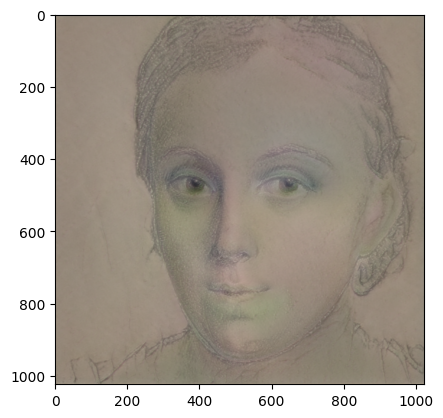

In [ ]:
projected_w='/content/drive/MyDrive/StyleGAN/out/rose2/projected_w1.npz'

ws = np.load(projected_w)['w']
ws = torch.tensor(ws, device=device) # pylint: disable=not-callable
assert ws.shape[1:] == (G.num_ws, G.w_dim)
for idx, w in enumerate(ws):
    img = G.synthesis(w.unsqueeze(0), noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img=img.to('cpu')
    plt.imshow(img[0])

## Network blending

In [ ]:
with open(model_list[0], 'rb') as f:
    G1 = pickle.load(f)['G_ema'].requires_grad_(False).to(device)#.cuda()  # torch.nn.Module
    
with open(model_list[1], 'rb') as f:
    G2 = pickle.load(f)['G_ema'].requires_grad_(False).to(device)#.cuda()  # torch.nn.Module

In [ ]:
steady_list=[]
for key in list(G1.state_dict().keys()):
  boolean=G1.state_dict()[key]==G2.state_dict()[key]
  boolean=boolean.to('cpu').numpy()
  if False not in np.unique(boolean):
    if key.split('.')[-1] not in steady_list:
      steady_list.append(key.split('.')[-1])

print(steady_list)
##전이학습을 해도 parameter값이 동일한 network
##resample_filter : upsample in G
## noise_const : noise after each convolution

['resample_filter', 'noise_const']


In [ ]:
def get_conv_names(model,max_dim):
    val = 1 + int(np.log2(max_dim / 4))  # 9 for 1024, 8 for 512
    resolutions = [4 * 2 ** x for x in range(val)]
    names = [x[0] for x in list(model.named_parameters())] #fine tuned networks
    level_names = [["conv0", "const"],["conv1", "torgb"]]
    position=0
    conv_names=[]
    for res in resolutions:
        rootname = f"synthesis.b{res}."
        for level, level_suffixes in enumerate(level_names): #conv0,const -> level 1 // conv1,torgb -> level 2
            for suffix in level_suffixes:
                searchname = rootname+suffix
                matches = [x for x in names if x.startswith(searchname)]
                info_tuples = [(name, f"b{res}",level,position) for name in matches]
                conv_names.extend(info_tuples)
            position+=1
    return conv_names

In [ ]:
def blend(G1, G2, resolution, level, network_size=1024, blend_width=None, verbose=True):

  model1_names=get_conv_names(G1,1024)
  model2_names=get_conv_names(G2,1024)

  assert model1_names==model2_names

  output_model = copy.deepcopy(G1)

  short_names = [(x[1:3]) for x in model1_names]
  full_names = [(x[0]) for x in model1_names]
  mid_point_idx = short_names.index((f'b{resolution}', level))
  mid_point_pos = model1_names[mid_point_idx][3]

  ys=[]
  for name, resolution, level, position in model1_names:
    x = position - mid_point_pos 
    if blend_width: #blend_width = None : hard blend / = float : soft blend(logistic)
        exponent = -x/blend_width #blend_width 작을수록 G2영향력 증가 
        y = 1 / (1 + math.exp(exponent))
    else:
        y = 1 if x > 1 else 0
    ys.append(y)
    if verbose:
        print(f"Blending {name} by {y}")
  #position이 mid_point보다 클수록 exponent 작아짐 -> y가 커짐 -> G2의 영향력 증가 = mid_point기준으로 해상도 큰 부분 G2로 & 해상도 작은 부분 G1으로
  new_model_state_dict = output_model.state_dict()
  for name, y in zip(full_names,ys):
    new_model_state_dict[name] = G2.state_dict()[name]*y+G1.state_dict()[name]*(1-y)

  output_model.load_state_dict(new_model_state_dict)

  return output_model

In [ ]:
def get_image(model, z=None, label=0, truncation_psi=0.7, noise_mode="const", w=None, is_w=False):
    if is_w:
        img = model.synthesis(w.unsqueeze(0), noise_mode=noise_mode)
    else:
        img = model(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    imgfile = PIL.Image.fromarray(img[0].cpu().numpy(), "RGB")

    return imgfile

In [115]:
resolutions=[4, 8, 16, 32, 64, 128, 256, 512, 1024]

blended_models={}
for resolution in resolutions:
  blended_models[f'b{resolution}']=blend(G1,G2,resolution,level=0,network_size=1024,blend_width=None,verbose=True)

Blending synthesis.b4.const by 0
Blending synthesis.b4.conv1.weight by 0
Blending synthesis.b4.conv1.noise_strength by 0
Blending synthesis.b4.conv1.bias by 0
Blending synthesis.b4.conv1.affine.weight by 0
Blending synthesis.b4.conv1.affine.bias by 0
Blending synthesis.b4.torgb.weight by 0
Blending synthesis.b4.torgb.bias by 0
Blending synthesis.b4.torgb.affine.weight by 0
Blending synthesis.b4.torgb.affine.bias by 0
Blending synthesis.b8.conv0.weight by 1
Blending synthesis.b8.conv0.noise_strength by 1
Blending synthesis.b8.conv0.bias by 1
Blending synthesis.b8.conv0.affine.weight by 1
Blending synthesis.b8.conv0.affine.bias by 1
Blending synthesis.b8.conv1.weight by 1
Blending synthesis.b8.conv1.noise_strength by 1
Blending synthesis.b8.conv1.bias by 1
Blending synthesis.b8.conv1.affine.weight by 1
Blending synthesis.b8.conv1.affine.bias by 1
Blending synthesis.b8.torgb.weight by 1
Blending synthesis.b8.torgb.bias by 1
Blending synthesis.b8.torgb.affine.weight by 1
Blending synthesis

In [ ]:
path=pathlib.Path('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out')
img_dir=list(path.glob('*'))
img_dir

[PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/.ipynb_checkpoints'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/rose1'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/rose2'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/monalisa'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/IU'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/Venus'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/chaeunwoo'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/myungsoo'),
 PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/macron')]

In [ ]:
img_dir=img_dir[1:]

In [ ]:
img_dir[1]

PosixPath('/content/drive/MyDrive/StyleGAN2/StyleGAN2-ada_Toonify/out/rose2')

In [116]:
mapped_type='w18_5000'
for dir in img_dir:
  projected_w=list(dir.glob('*{}.npz'.format(mapped_type)))
  if len(projected_w)!=0:
    ws = np.load(projected_w[0])['w']
    ws = torch.tensor(ws, device=device)
    fig,axes=plt.subplots(3,3,figsize=(15,15))
    for ax,model in zip(axes.ravel(),blended_models):
      m=blended_models[model]
      assert ws.shape[1:] == (m.num_ws, m.w_dim)
      img=get_image(model=blended_models[model],w=ws[0],is_w=True)
      ax.imshow(img)
      ax.set_title(f'{model} blended_model')
    plt.show()

In [ ]:
projected_w='/content/drive/MyDrive/StyleGAN/out/rose2/projected_w1.npz'
ws = np.load(projected_w)['w']
ws = torch.tensor(ws, device=device)

for model in blended_models:
  print(model,'blended_model')
  m=blended_models[model]
  assert ws.shape[1:] == (m.num_ws, m.w_dim)
  img=get_image(model=blended_models[model],w=ws[0],is_w=True)
  plt.figure(figsize=(5,5))
  plt.imshow(img)
  plt.show()
  #display(img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
projected_w='/content/drive/MyDrive/StyleGAN/out/rose2/projected_w18_5000.npz'
ws = np.load(projected_w)['w']
ws = torch.tensor(ws, device=device)

for model in blended_models:
  print(model,'blended_model')
  m=blended_models[model]
  assert ws.shape[1:] == (m.num_ws, m.w_dim)
  img=get_image(model=blended_models[model],w=ws[0],is_w=True)
  plt.figure(figsize=(15,5))
  plt.imshow(img)
  plt.show()
  #display(img)

Output hidden; open in https://colab.research.google.com to view.

(1, 18, 512)


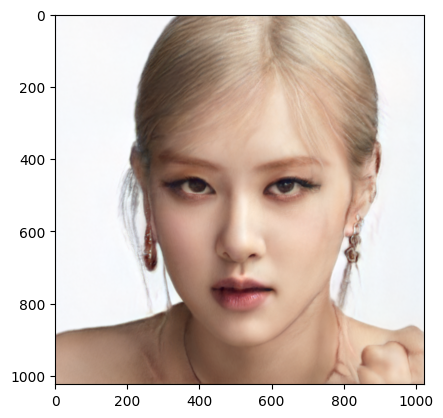

In [ ]:
projected_w='/content/drive/MyDrive/StyleGAN/out/rose2/projected_w18_5000.npz'

ws = np.load(projected_w)['w']
print(ws.shape)
ws = torch.tensor(ws, device=device) # pylint: disable=not-callable
assert ws.shape[1:] == (G.num_ws, G.w_dim)
for idx, w in enumerate(ws):
    img = G.synthesis(w.unsqueeze(0), noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8) #G로 생성하면 정규화돼서 나옴
    img=img.to('cpu')
    plt.imshow(img[0])